In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sysidentpy.metrics import mean_squared_error, mean_absolute_error
from sysidentpy.utils.generate_data import get_siso_data
from sklearn.metrics import r2_score


In [2]:
# Load a dataset of a simulated dynamical system
file_path = 'robot_arm.dat'
try:
    robot_data = pd.read_csv(file_path, delimiter='\t')

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


In [3]:
X = robot_data.iloc[:, 0].values.reshape(-1, 1)
Y = robot_data.iloc[:, 1].values.reshape(-1, 1)

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, test_size=0.3)
print(x_train.shape)
print(y_train.shape)

(716, 1)
(716, 1)


In [98]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.utils.narmax_tools import regressor_code
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)



basis_function = Polynomial(degree=4)
estimator = LeastSquares()
model = FROLS(
    order_selection=True,
    n_info_values=3,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator=estimator,
    err_tol=None,
    basis_function=basis_function,
)
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = mean_absolute_error(y_valid, yhat)
print(rrse)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

r2 = r2_score(y_valid,yhat)
print(r2)

764.259157140757
              Regressors  Parameters             ERR
0               y(k-1)^4  6.8853E-01  1.15578311E-02
1  x1(k-2)y(k-2)y(k-1)^2  6.1822E+00  1.09005570E-02
2        x1(k-1)^2y(k-2)  2.7042E+00  1.15470119E-02
0.005032933035175824


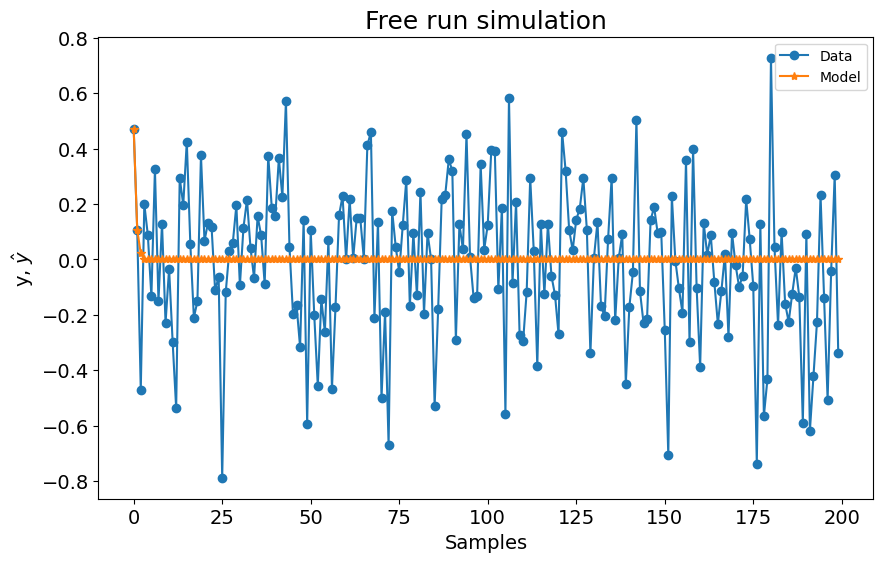

In [80]:
plot_results(y=y_valid, yhat=yhat, n=200)
#ee = compute_residues_autocorrelation(y_valid, yhat)
#plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
#x1e = compute_cross_correlation(y_valid, yhat, x_valid)
#plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

In [81]:
print(x_train.shape)

(716, 1)


0.28646594353545707
-0.7226730081173633


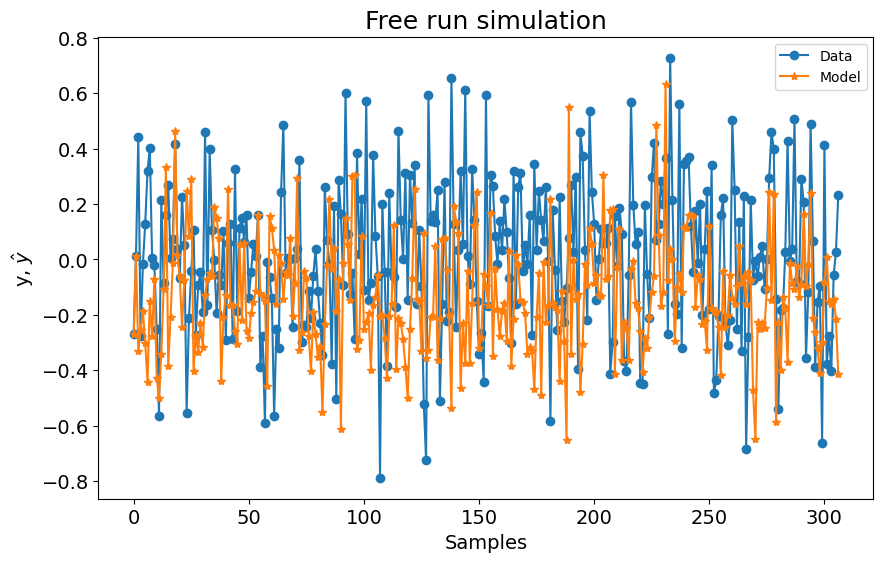

In [7]:
from torch import nn
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 500)
        self.lin2 = nn.Linear(500, 200)
        self.lin3 = nn.Linear(200, 100)
        self.lin4 = nn.Linear(100, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        z = self.tanh(z)
        z = self.lin4(z)
        return z

basis_function=Polynomial(degree=1)

narx_net = NARXNN(
    net=NARX(),
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=1000,
    verbose=False,
    optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

narx_net.fit(X=x_train, y=y_train)
yhat = narx_net.predict(X=x_valid, y=y_valid)
rrse = mean_absolute_error(y_valid, yhat)
print(rrse)
r2 = r2_score(y_valid,yhat)
print(r2)

plot_results(y=y_valid, yhat=yhat,n=1000)


0.2540842059346668
-0.3242218394384231


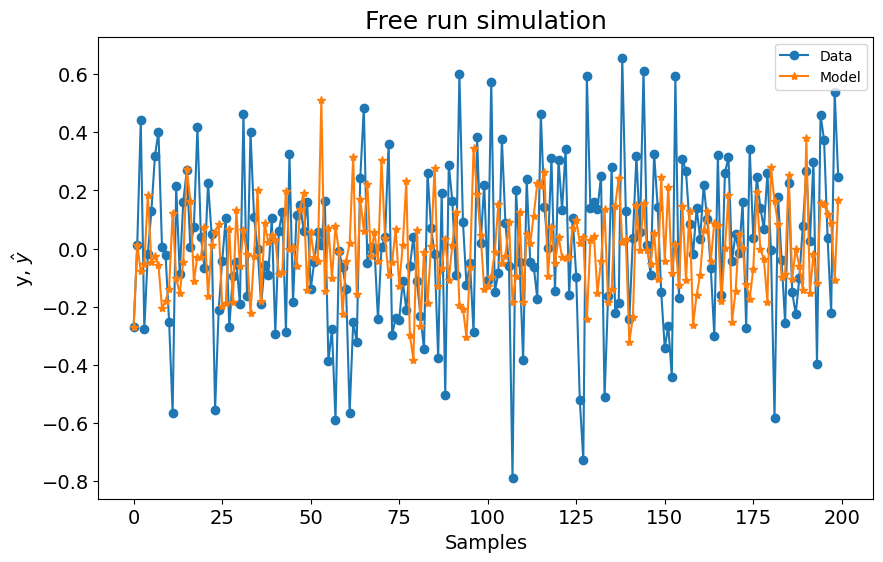

In [11]:
from sysidentpy.general_estimators import NARX
from sysidentpy.basis_function._basis_function import Fourier
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

basis_function = Fourier(degree=1)
# define the scikit estimator
scikit_estimator = BayesianRidge()
# transform scikit_estimator into NARX model
gb_narx = NARX(
    base_estimator=scikit_estimator,
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
)

gb_narx.fit(X=x_train, y=y_train)
yhat = gb_narx.predict(X=x_valid, y=y_valid)

# XGboost examples
xgb_estimator = xgb.XGBRegressor()
xgb_narx = NARX(
    base_estimator=xgb_estimator,
    xlag=2,
    ylag=2,
    basis_function=basis_function,
    model_type="NARMAX",
)

xgb_narx.fit(X=x_train, y=y_train)
yhat = xgb_narx.predict(X=x_valid, y=y_valid)
rrse = mean_absolute_error(y_valid, yhat)
print(rrse)
r2 = r2_score(y_valid,yhat)
print(r2)
plot_results(y=y_valid, yhat=yhat, n=200)
